This notebook estimates bus arrival time using gaussian processes.

First off lets get some libraries into scope, set the seed and load the data.

In [39]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sb
import pandas as pd
import time
from datetime import datetime

sns.set(style="darkgrid")
np.random.seed(1)
data = pd.read_csv('bus203_all.csv')
n = len(data)

Lets take a look at the data and plot the coordinates

In [3]:
 def gt(dt_str):
        dt, _, us= dt_str.partition(".")
        dt= datetime.strptime(dt, "%Y-%m-%dT%H:%M:%S")
        return dt
    


In [4]:
data.head()

,Unnamed: 0,timestamp,event,vehicle_id,line,longitude,latitude,direction,speed,station,journey_number,segment_number
0,0,2018-02-16T04:48:40.0000000+01:00,JourneyStartedEvent,5432,203,58.414238,15.571015,-1.000000,-1.0,NaN,1,1
1,1,2018-02-16T04:48:40.0000000+01:00,ObservedPositionEvent,5432,0,58.414238,15.571015,147.300003,0.0,NaN,1,1
2,2,2018-02-16T04:48:40.0000000+01:00,ArrivedEvent,5432,203,58.414238,15.571015,-1.000000,-1.0,Rydsv\xe4gens \xe4ndh\xe5llpl.,1,1
3,3,2018-02-16T04:48:41.0000000+01:00,ObservedPositionEvent,5432,0,58.414246,15.571012,147.300003,0.0,NaN,1,1
4,4,2018-02-16T04:48:42.0000000+01:00,ObservedPositionEvent,5432,0,58.414249,15.571008,147.300003,0.0,NaN,1,1


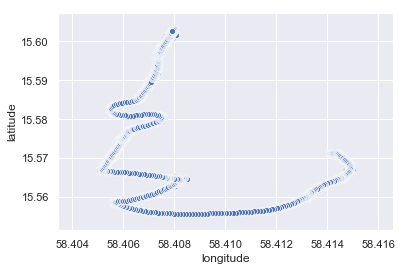

In [8]:
sb.scatterplot(x="longitude", y="latitude", data=data)

The goal is to estimate arrival time given a coordinate, but to do that we first need to annotate the trajectories in the data with the actual arrival times. The chunk below will process the data to extract the time until next stop and put that into the file "data.pkl" which can then be loaded into a data frame. Consequently this snippet only needs to be run if we want to change the data. This took me 20 minutes and the resulting file is a 4gb pickle file that contains less info than the 1 gb csv file.

In [61]:
def parse_time(dt_str):
    dt, _, _ = dt_str.partition(".")
    return datetime.strptime(dt, "%Y-%m-%dT%H:%M:%S")
    
t0 = time.time()
last_stop_timestamp = datetime.utcnow()
data_to_process = data # data.loc[data['journey_number'] == 1]
ts = pd.DataFrame(np.zeros(data_to_process.size), columns=list('t'))

pickle_file = 'data.pkl'

for i, d in reversed(list(data_to_process.iterrows())):
    t = parse_time(d['timestamp'])
    if d['event'] == 'EnteredEvent':
        last_stop_timestamp = t
    else:
         ts.iloc[i] = (last_stop_timestamp - t).seconds

elapsed = time.time() - t0
print("Data pickled in", elapsed, " seconds")


gp_df = pd.concat([
            data_to_process['latitude'], 
            data_to_process['longitude'], 
            data_to_process['journey_number'], 
            data_to_process['segment_number'], 
            data_to_process['speed'], 
            ts],
            axis = 1)
print(len(ts))
print(len(gp_df))
gp_renamed = gp_df.rename(columns = {
                        'latitude': 'lat', 
                        'longitude': 'long', 
                        'journey_number': 'traj', 
                        'segment_number': 'seg', 
                        'speed': 'sped', 
                        't': 't'})

gp_renamed.to_pickle(pickle_file)



Data pickled in 1295.6178209781647  seconds
83156088
83156088


We can now load the data and plot the first trajectory and segment

In [63]:
df = pd.read_pickle(pickle_file)
traj_one_df = df[df.traj == 1]

MemoryError: 

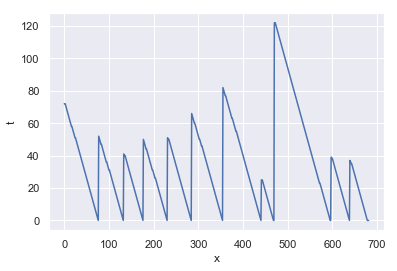

In [69]:
# All segments
df = pd.concat([traj_one_df, pd.DataFrame(traj_one_df.index.tolist(), columns=list('x'))], axis=1)
sb.lineplot(data=df, x='x', y='t')

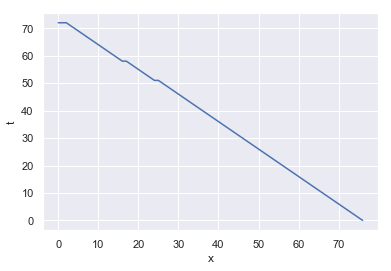

In [78]:
# The first segment
seg1 = traj_one_df[traj_one_df.seg == 1]
seg1 = pd.concat([seg1, pd.DataFrame(seg1.index.tolist(), columns=list('x'))], axis=1)
sb.lineplot(data=seg1, x='x', y='t')

This looks like something we'd expect! 

That was the easy stuff, now the data needs to be synchronised somehow. 

In [ ]:
# Do all the hard stuff with synchonisation

Hopefully everything was synchronised nicely. I have included some code for gaussian process regression and posterior sampling using HMC below, but it is currently completely disconnected with the stuff above.

Lets first define a model with a matern52 kernel and some arbitrary lenghtscale

In [73]:
k = gpflow.kernels.Matern52(1, lengthscales=0.3)
meanf = gpflow.mean_functions.Linear(1.0, 0.0)
m = gpflow.models.GPR(X, Y, k, meanf)
m.likelihood.variance = 0.01

NameError: name 'X' is not defined

The code below will learn the parameters using ML

In [49]:
m.compile()
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -512.114037
  Number of iterations: 32
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -512.114037
  Number of iterations: 32
  Number of functions evaluations: 38


In [ ]:
Lets plot the fit

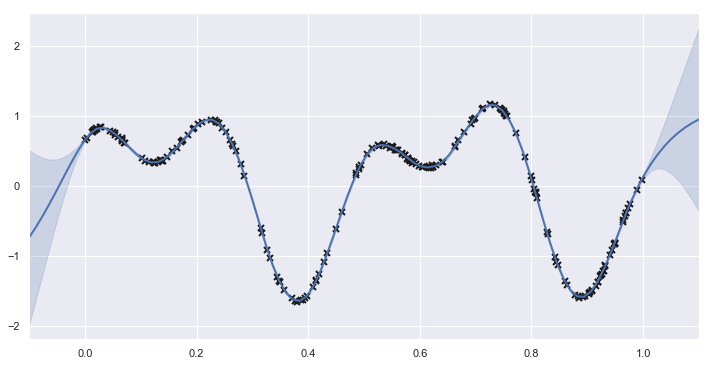

In [50]:
def plot(m):
    xx = np.linspace(-0.1, 1.1, 100).reshape(100, 1)
    mean, var = m.predict_y(xx)
    plt.figure(figsize=(12, 6))
    plt.plot(X, Y, 'kx', mew=2)
    plt.plot(xx, mean, 'C0', lw=2)
    plt.fill_between(xx[:,0],
                     mean[:,0] - 2*np.sqrt(var[:,0]),
                     mean[:,0] + 2*np.sqrt(var[:,0]),
                     color='C0', alpha=0.2)
    plt.xlim(-0.1, 1.1)
    
plot(m)

The fit looks pretty neat! Now lets put priors on the hyperparameters and sample the posterior

In [51]:
m.clear()
m.kern.lengthscales.prior = gpflow.priors.Gamma(1., 1.)
m.kern.variance.prior = gpflow.priors.Gamma(1., 1.)
m.likelihood.variance.prior = gpflow.priors.Gamma(1., 1.)
m.mean_function.A.prior = gpflow.priors.Gaussian(0., 10.)
m.mean_function.b.prior = gpflow.priors.Gaussian(0., 10.)
m.compile()
m.as_pandas_table()


,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,"Ga(1.0,1.0)",+ve,True,(),True,0.21741004094070154
GPR/kern/variance,Parameter,"Ga(1.0,1.0)",+ve,True,(),True,4.494731104798825
GPR/likelihood/variance,Parameter,"Ga(1.0,1.0)",+ve,True,(),True,0.0001051296987412428
GPR/mean_function/A,Parameter,"N(0.0,10.0)",(none),True,"(1, 1)",True,[[1.275035218652909]]
GPR/mean_function/b,Parameter,"N(0.0,10.0)",(none),True,(),True,-0.6666629439058851


and use HMC to sample the posterior. The parameters estimated by ML will be the starting position of the sampler.

In [54]:
sampler = gpflow.train.HMC()
samples = sampler.sample(m, 
                         num_samples=gpflow.test_util.notebook_niter(500), 
                         epsilon=0.05, 
                         lmin=10, 
                         lmax=20, 
                         logprobs=False)

plt.figure(figsize=(8,4))
for i, col in samples.iteritems():
    plt.plot(col, label=col.name)
plt.legend(loc=0)
plt.xlabel('hmc iteration')
plt.ylabel('parameter value')

TypeError: sample() got an unexpected keyword argument 'verbose'

In [ ]:
Plotting the Markov chains of the posterior samples above show that they 
unfortunately do not mix very well so convergence will be slow. 

In the plot below we see posterior samples and the true data. This shows 
meaningful results, but a lot of functions seem to have too low variance, 
indicating the hyperparameter

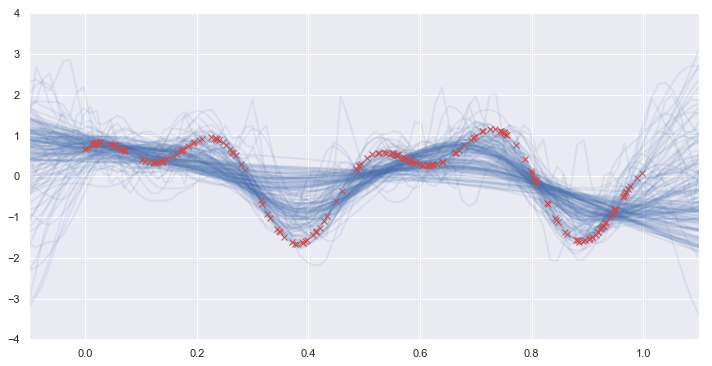

In [53]:
xx = np.linspace(-0.1, 1.1, 100)[:,None]
plt.figure(figsize=(12, 6))
for i, s in samples.iloc[::20].iterrows():
    f = m.predict_f_samples(xx, 1, initialize=False, feed_dict=m.sample_feed_dict(s))
    plt.plot(xx, f[0,:,:], 'C0', lw=2, alpha=0.1)

plt.plot(X, Y, 'rx')
_ = plt.xlim(xx.min(), xx.max())
_ = plt.ylim(-4, 4)